In [1]:
from scipy.misc import derivative
import logging
from functools import lru_cache
from scipy.optimize import least_squares
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from  functools import partial
logger = logging.getLogger()
logger.setLevel(logging.INFO)
R0 = 6378*10**3#m   the radius of the Earth
g0 = 9.81#m/s^2  Earth gravitational acceleration at R0
m = 37362#kg   dimensional mass of the vehicle
Sref = 149.4#m^2 the dimensional reference area of the vehicle
omega = 7.2921*10**(-5)*np.sqrt(R0/g0)#rotational angular velocity of the earths
kQ = 9.4369*10**(-5)
Qmax = 800*10**3#W/m^2  maximum heat rate
qmax = 14364#N/m^2   maximum dynamic pressure
nmax = 2.5# in g0   maximum normal load factor
vmin = 0/180*np.pi  # absolute minimum value of bank angle
vmax = 165/180*np.pi  # absolute maximum value of bank angle
H0 = 121.9*10**3#m   initial altitude
Hf = 30.48*10**3#m   final altitude
r0 = (H0+R0)/R0  #initial nondimensional radial distance from the center of the Earth
rf = (Hf+R0)/R0  #final nondimensional radial distance from the center of the Earth
theta0 = 237/180*np.pi  #initial longitude
thetaf = 279/180*np.pi  #final longitude
fai0 = -25/180*np.pi  #initial latitude
faif = 28.61/180*np.pi  #final latitude
V0 = 7626/np.sqrt(g0*R0)#  initial nondimensional velocity
Vf = 908.15/np.sqrt(g0*R0)  #final nondimensional velocity
gamma0 = -1.2493/180*np.pi #initial relative flight-path angle
gammaf = np.array([-6,0])/180*np.pi#final relative flight-path angle
polyfai0 = 45/180*np.pi  #initial heading angle of the relative velocity vector
polyfaif = np.array([85,90])/180*np.pi  #final heading angle of the relative velocity vector
delta = [20000/R0,20*np.pi/180,20*np.pi/180,20*np.pi/180,70*np.pi/180]  #trust-region constraint
epsilon = [200/R0,0.05*np.pi/180,0.05*np.pi/180,0.05*np.pi/180,0.05*np.pi/180]  #stopping criteria
kC = 1 # Variance Weights for Path Constraints
kJ = 3 # Variance Weights for longitude and latitude
N_points = 301
n = 3  # Number of points in one dimension
p = 2  # Degree of the polynomial
d = 3  # Dimension of the random variable
nOfS = n**d # Number of points in the stochastic space
deterministic_idx = 14
nOfP = int(np.math.factorial(p+d)/(np.math.factorial(p)*np.math.factorial(d))) # Number of terms in the polynomial
# sigma_X0 = [1000/R0,0.1*np.pi/180,0.1*np.pi/180,0.1*np.pi/180,0.1*np.pi/180]
deviation_Rho = 0.05 # standard deviation  of atmospheric density
deviation_CL = 0.05  # standard deviation  of CL
deviation_CD = 0.05  # standard deviation  of CD
e0 = 1/r0-V0**2/2  #initial nondimensional energy
ef = 1/rf-Vf**2/2  #final nondimensional energy
e_values = None
de = (ef-e0)/(N_points-1)
dei = None
dei_1 = None
S_tmp,weights_tmp = np.polynomial.hermite.hermgauss(n)# Gauss-Hermite quadrature point

In [2]:
# This Cell is a utility class used to assist in writing other functions.
def find_kth_combination(k, m,n=n):
    base = n ** (m - 1)
    result = []

    for i in range(m, 0, -1):
        index = (k - 1) // base
        result.append(index + 1)
        k -= index * base
        base //= n

    return result
def find_matrices_recursive(N,R, C, matrix, row, col, solutions):
    if row == N:
        if all([R[i] == 0 for i in range(N)]) and all([C[i] == 0 for i in range(N)]):
            solutions.append([matrix[i].copy() for i in range(N)])
        return
    if R[row] == 0:
        find_matrices_recursive(N,R, C, matrix, row + 1, 0, solutions)
        return
    if C[col] == 0:
        if col + 1 < N:
            find_matrices_recursive(N,R, C, matrix, row, col + 1, solutions)
        else:
            find_matrices_recursive(N,R, C, matrix, row + 1, 0, solutions)
        return
    next_row, next_col = (row, col + 1) if col + 1 < N else (row + 1, 0)
    for value in range(min((R[row], C[col])) + 1):
        ori = matrix[row][col]
        matrix[row][col] = value
        R[row] -= value  
        C[col] -= value  
        if R[row] >= 0 and C[col] >= 0:  
            find_matrices_recursive(N,R, C, matrix, next_row, next_col, solutions) 
        R[row] += value  
        C[col] += value  
        matrix[row][col] = ori  
@lru_cache(maxsize=None)
def find_matrices(R, C):
    assert len(R) == len(C), "The length of R and C should be the same"
    N = len(R)
    if isinstance(R, tuple):
        R = list(R)  
    if isinstance(C, tuple):
        C = list(C)  
    solutions = []
    matrix = [[0 for _ in range(N)] for _ in range(N)]  
    try:
        find_matrices_recursive(N,R, C, matrix, 0, 0, solutions)
    except Exception as e:
        logging.debug(f"find_matrices:R={R},C={C},e={e}")
        raise e
    return solutions

@lru_cache(maxsize=None)
def comb(n, k):
    return np.math.factorial(n) // (np.math.factorial(k) * np.math.factorial(n - k))
def find_sequence_general(k, m):
    '''按照m个数字的总和从小到大排列，找到第k个序列，如find_sequence_general(0,3)=[0,0,0],find_sequence_general(1,3)=[0,0,1]'''
    n = 0
    while True:
        
        count = comb(n + m - 1, m - 1)
        if k < count:
            break
        k -= count
        n += 1
    
    sequence = []
    for _ in range(m - 1):
        for x in range(n + 1):
            if comb(n - x + m - 2, m - 2) > k:
                sequence.append(x)
                n -= x
                m -= 1
                break
            else:
                k -= comb(n - x + m - 2, m - 2)
    sequence.append(n)
    
    return tuple(sequence)
def evenly_sample_array(arr, num_samples=200):
    n = len(arr)
    indices = np.round(np.linspace(0, n - 1, num=num_samples)).astype(int)
    sampled_points = arr[indices]
    
    return sampled_points
def lsolution(func,upperbound):
    r_solutions = []
    for e in e_values:
        if len(r_solutions)==0:
            res = least_squares(lambda r:func(e,r)-upperbound,x0=r0, bounds =(1,np.inf),ftol=3e-16,xtol=3e-16,gtol=3e-16)
        else:
            res = least_squares(lambda r:func(e,r)-upperbound,x0=r_solutions[-1], bounds =(1,np.inf),ftol=3e-16,xtol=3e-16,gtol=3e-16)
        if not res.success:
            logging.debug(f"lsolution:res={res}")
        assert len(res.x)==1,"lsolution:res.x should be a scalar"
        r_solutions.append(res.x[0])
    r_solutions = np.array(r_solutions)
    return r_solutions

In [3]:
# This Cell is a utility class used for Polynomial Chaos Expansions
def Sj(j,sigma=(deviation_Rho,deviation_CL,deviation_CD)):
    l = len(sigma)
    ind = find_kth_combination(j,l)
    return [np.sqrt(2)*sigma[i]*S_tmp[ind[i]-1] for i in range(l)]
assert np.all(np.array(Sj(deterministic_idx))==0),"Sj(deterministic_idx) should be all zeros"
def weightj(j,sigma=(deviation_Rho,deviation_CL,deviation_CD)):
    l = len(sigma)
    ind = find_kth_combination(j,l)
    return np.prod([weights_tmp[ind[i]-1]/(np.sqrt(np.pi)) for i in range(l)])
def hermite_polynomial(x,n,sigma=(deviation_Rho,deviation_CL,deviation_CD)):#计算Hermite多项式的值
    if isinstance(x,(int,float)):
        x = (x,)
    if isinstance(sigma,(int,float)):
        sigma = (sigma,)
    variable_len = len(x)
    assert variable_len == len(sigma), "The length of x and sigma should be the same"
    seq = find_sequence_general(n,variable_len)
    result = 1
    for i in range(variable_len):
        c = np.zeros(seq[i]+1)
        c[seq[i]] = 1
        result *= np.polynomial.hermite.hermval(x[i]/(np.sqrt(2)*sigma[i]),c)/((np.sqrt(2)*sigma[i])**seq[i])
    norm = 1
    for i,k in enumerate(seq):
        norm *= np.math.factorial(k)
    norm = norm**2
    solutions = find_matrices(seq,seq)
    tmp = 0
    def sigma_inverse(sigma,m,n):
        if m==n:
            return 1/(sigma[m]**2)
        else:
            return 0
    for solution in solutions:
        tmp+=np.prod([(sigma_inverse(sigma,m,n))**solution[m][n]/np.math.factorial(solution[m][n]) for m in range(variable_len) for n in range(variable_len)])
    norm = norm*tmp
    return result/np.sqrt(norm)
def coefficients_matrix(l,sigma=(deviation_Rho,deviation_CL,deviation_CD)):#计算多项式的系数,func(x,y,z)=\sum_{i,j,k}c_{i,j,k}H_i(x/(sqrt(2)\sigma))H_j(y/(sqrt(2)\sigma))H_k(z/(sqrt(2)\sigma))
    '''求c_{i,j,k}的值，func是关于x,y,z的函数'''
    return np.array([weightj(i,sigma)*hermite_polynomial(tuple(Sj(i,sigma)),l,sigma) for i in range(nOfS)])
def quadratrue(f_vals):
    integral = 0.5 * cp.sum(cp.multiply((f_vals[:-1] + f_vals[1:]) , (e_values.flatten()[1:] - e_values.flatten()[:-1])))
    return integral
def Variance_matrix(p=p,sigma=(deviation_Rho,deviation_CL,deviation_CD),isindex=False):#计算方差
    '''计算标准差，func(x,y,z)是关于x,y,z的函数,p是多项式的阶数'''
    result = 0
    P = int(np.math.factorial(p+d)/(np.math.factorial(p)*np.math.factorial(d)))
    for l in range(1,P+1):
        tmp = coefficients_matrix(l,sigma)
        result+=tmp.reshape(-1,1)@tmp.reshape(1,-1)
    return result
def Expectation_matrix(sigma=(deviation_Rho,deviation_CL,deviation_CD)):#计算期望
    '''计算期望，func(x,y,z)是关于x,y,z的函数'''
    return coefficients_matrix(0,sigma)

In [4]:
# This Cell is a utility class used for Trajectory Dynamics parameters
def Calcu_CLCD(alpha, mach,isCD=False):
    x = alpha
    y = mach
    
    mask = y<=5
    if isCD:
        CD = np.zeros_like(x)
        a_D = 0.1908219490086461
        b_D = 0.7921786756723015
        c_D = 81.77767906793568
        d_D = 0.7608546899234436
        e_D = -0.06715377897523668
        f_D = 4.809129538309562
        g_D = -0.8220180925372075
        z1_D = np.exp(-0.5 * (np.log(x / c_D) / d_D) ** 2)
        z2_D = np.exp(-0.5 * ((y - f_D) / g_D) ** 2)
        z_D = a_D + b_D * z1_D + e_D * z2_D
        CD[mask] = z_D[mask]
        a_D = 0.2893865934644147
        b_D = 0.7101395427838309
        c_D = 44.69254972733151
        d_D = 12.43577575552023
        e_D = -0.243653871914911
        f_D = 5.428869369818743
        g_D = 0.2330424954375339
        hh_D = 1.098649201604347
        z1_D = 1.0 / (1.0 + np.exp(-(x - c_D) / d_D))
        z2_D = 1.0 / (1.0 + np.exp(-(y - f_D) / g_D))
        z_D = a_D + b_D * z1_D + e_D * z2_D + hh_D * z1_D * z2_D
        CD[~mask] = z_D[~mask]
        return CD
    else:
        CL = np.zeros_like(x)
        a_L = 0.6736442631404929
        b_L = -0.2396729544298644
        c_L = 0.02354634960855771
        d_L = 0.5137518146743224
        e_L = 35.7738334917245
        f_L = 0.5482342780270542
        z1_L = np.exp(-0.5 * (np.log(x / e_L) / f_L) ** 2)
        z2_L = y * (b_L + c_L * y)
        z_L = a_L + z2_L + d_L * z1_L
        CL[mask] = z_L[mask]
        a_L = -0.2361725195924329
        b_L = 1.037601261644054
        c_L = 50.11901193898274
        d_L = 26.17064737989058
        e_L = 0.8761093802115429
        f_L = 4.857160518263465
        g_L = -0.485173805363233
        hh_L = -1.164121063690802
        z1_L = np.exp(-0.5 * ((x - c_L) / d_L) ** 2)
        z2_L = np.exp(-0.5 * ((y - f_L) / g_L) ** 2)
        z_L = a_L + b_L * z1_L + e_L * z2_L + hh_L * z1_L * z2_L
        CL[~mask] = z_L[~mask]
        return CL
CL = lambda alpha,mach,CLdelta=0: Calcu_CLCD(alpha,mach, isCD=False)*(1+CLdelta)#升力系数,alpha是攻角，单位度
CD = lambda alpha,mach,CDdelta=0: Calcu_CLCD(alpha,mach, isCD=True)*(1+CDdelta)#阻力系数,alpha是攻角，单位度
def calculate_temperature(heights):
    is_number = isinstance(heights, (int, float))
    if is_number:  # Check if the value is int or float
        heights =np.array([heights])         # Convert it to a numpy array and return
    T_0 = 288.15  # 初始温度，单位: K
    temperatures = np.full(heights.shape, T_0)
    layers = np.array([
        (0, -6.5),
        (11, 0.0),
        (20, 1.0),
        (32, 2.8),
        (47, 0.0),
        (51, -2.8),
        (71, -2.0),
        (85, np.nan)  # 85km以上的温度梯度不明确
    ])
    for i in range(len(layers) - 1):
        # 高度属于当前层的掩码
        mask = (heights >= layers[i, 0]) & (heights < layers[i+1, 0])
        mask2 = (heights >= layers[i, 0])&(heights >= layers[i+1, 0])
        # 计算对应层的温度变化并累加
        temperatures += np.where(mask, layers[i, 1] * (heights - layers[i, 0]), 0)
        temperatures += np.where(mask2, layers[i, 1] * (layers[i+1, 0] - layers[i, 0]), 0)
    # 对于高度在最后一个已知层以上的情况，温度不变，仍然使用最后一个已知层的温度
    if is_number:
        return temperatures[0]
    return temperatures
def sound_speed(r):#声速，无量纲,r是无量纲
    T = calculate_temperature((r-1)*R0/1000)
    return (331.6+0.6*(T-273.15))/np.sqrt(g0*R0)
def Rho(r,Rhodelta=0):#Atmospheric density in units of kg/m^3, where r is dimensionless, applicable for altitudes h>25km
    return (1.225*np.exp(-(r-1)*R0*13.785e-5))*(1+Rhodelta)
def Rho_r(r,Rhodelta=0):#derivative of Atmospheric density with respect to r
    return -Rho(r,Rhodelta=Rhodelta)*R0*13.785e-5
def alpha(Mach):#攻角，单位度
    return 45-0.612*(np.maximum(10-Mach,0))**2
def V(e,r):#速度，无量纲，e是能量，r是无量纲
    assert np.all(e<=1/r),f"V:e should be smaller than 1/r, e={e},r={r},e-1/r={e-1/r},np.max(e-1/r)={np.max(e-1/r)},np.argmax(e-1/r)={np.argmax(e-1/r)}"
    return np.sqrt(2*(1/r-e))
def L(e,r,CLdelta=0,Rhodelta=0):#aerodynamic lift acceleration in g0
    Mach = V(e,r)/sound_speed(r)
    return 0.5*R0*Rho(r,Rhodelta=Rhodelta)*V(e,r)**2*Sref*CL(alpha(Mach),Mach,CLdelta=CLdelta)/(m)
def D(e,r,CDdelta=0,Rhodelta=0):#aerodynamic drag acceleration in g0
    Mach = V(e,r)/sound_speed(r)
    return 0.5*R0*Rho(r,Rhodelta=Rhodelta)*V(e,r)**2*Sref*CD(alpha(Mach),Mach,CDdelta=CDdelta)/(m)
def Dr(e,r,CDdelta=0,Rhodelta=0):#derivative of D with respect to r
    Mach = V(e,r)/sound_speed(r)
    dMach = -V(e,r)/(sound_speed(r)**2)*derivative(lambda r:sound_speed(r),r,dx=1e-7)
    dCD = derivative(lambda mach:CD(alpha(mach),mach,CDdelta=CDdelta),Mach,dx=1e-7)
    return 0.5*R0*Rho_r(r,Rhodelta=Rhodelta)*V(e,r)**2*Sref*CD(alpha(Mach),Mach,CDdelta=CDdelta)/(m)+\
            0.5*R0*Rho(r,Rhodelta=Rhodelta)*V(e,r)**2*Sref*dCD*dMach/(m)
def n_value(e,r,CLdelta=0,CDdelta=0,Rhodelta=0):#normal load factor
    return np.sqrt(L(e,r,CLdelta=CLdelta,Rhodelta=Rhodelta)**2+D(e,r,CDdelta=CDdelta,Rhodelta=Rhodelta)**2)
def q_value(e,r,Rhodelta=0):#dynamic pressure
    return 0.5*g0*R0*Rho(r,Rhodelta=Rhodelta)*V(e,r)**2
def Q_value(e,r,Rhodelta=0):#heat rate
    return kQ*np.sqrt(g0*R0)**3.15*np.sqrt(Rho(r,Rhodelta=Rhodelta))*(V(e,r))**3.15
def sigma_t(t):#initial bank angle
    if t < 160:
        sigma = 0 
    elif 160 <= t and t < 600:
        sigma = -65 
    elif 600 <= t and t < 1000:
        sigma = -50 
    else:
        sigma = 45
    return sigma

In [5]:
# This Cell is a utility class used for Convex Optimizaiton
def Ak(r,theta,fai,gamma,polyfai):
    '''计算A矩阵,r,theta,fai,gamma,polyfai是无量纲,且r[i,j]表示r(e_i,s_j),u=[cos(mu),sin(mu)]'''
    S = np.array([Sj(i,sigma=(deviation_Rho,deviation_CL,deviation_CD)) for i in range(nOfS)])
    Drk = Dr(e_values,r,CDdelta=S[:,2],Rhodelta=S[:,0])
    Dk = D(e_values,r,CDdelta=S[:,2],Rhodelta=S[:,0])
    sin_gammak = np.sin(gamma)
    cos_gammak = np.cos(gamma)
    sin_fai = np.sin(fai)
    cos_fai = np.cos(fai)
    tan_fai = np.tan(fai)
    sin_polyfai = np.sin(polyfai)
    cos_polyfai = np.cos(polyfai)
    Vk = V(e_values,r)
    a11 = -Drk*sin_gammak/(Dk**2)
    a14 = cos_gammak/(Dk)
    a21 = -(Drk/(r*Dk**2)+1/(r**2*Dk))*cos_gammak*sin_polyfai/cos_fai
    a23 = cos_gammak*sin_polyfai*sin_fai/(r*Dk*cos_fai**2)
    a24 = -sin_gammak*sin_polyfai/(r*Dk*cos_fai)
    a25 = cos_gammak*cos_polyfai/(r*Dk*cos_fai)
    a31 = -(Drk/(r*Dk**2)+1/(r**2*Dk))*cos_gammak*cos_polyfai
    a34 = -sin_gammak*cos_polyfai/(r*Dk)
    a35 = -cos_gammak*sin_polyfai/(r*Dk)
    a41 = Drk*cos_gammak/(Dk**2*r)*(1/(r*Vk**2)-1)+cos_gammak/(Dk*r**2)*(2/(r*Vk**2)-1)
    a44 = sin_gammak/(Dk*r)*(1/(r*Vk**2)-1)
    a51 = -cos_gammak*sin_polyfai*tan_fai*(Drk/(r*Dk**2)+1/(r**2*Dk))
    a53 = cos_gammak*sin_polyfai/(r*Dk*cos_fai**2)
    a54 = -sin_gammak*sin_polyfai*tan_fai/(r*Dk)
    a55 = cos_gammak*cos_polyfai*tan_fai/(r*Dk)
    zeros = np.zeros_like(a11)
    A =          [[a11,zeros,zeros,a14,zeros],
                [a21,zeros,a23,a24,a25],
                [a31,zeros,zeros,a34,a35],
                [a41,zeros,zeros,a44,zeros],
                [a51,zeros,a53,a54,a55]]
    return np.array(A)
def Bk(r,theta,fai,gamma,polyfai):
    S = np.array([Sj(i,sigma=(deviation_Rho,deviation_CL,deviation_CD)) for i in range(nOfS)])
    Drk = Dr(e_values,r,CDdelta=S[:,2],Rhodelta=S[:,0])
    Dk = D(e_values,r,CDdelta=S[:,2],Rhodelta=S[:,0])
    sin_gammak = np.sin(gamma)
    cos_gammak = np.cos(gamma)
    sin_fai = np.sin(fai)
    cos_fai = np.cos(fai)
    tan_fai = np.tan(fai)
    sin_polyfai = np.sin(polyfai)
    cos_polyfai = np.cos(polyfai)
    Vk = V(e_values,r)
    Lk = L(e_values,r,CLdelta=S[:,1],Rhodelta=S[:,0])
    b41 = Lk/Dk/(Vk**2)
    b52 = Lk/(Vk**2*cos_gammak*Dk)
    zeros = np.zeros_like(b41)
    B = [[zeros,zeros],
            [zeros,zeros],
            [zeros,zeros],
            [b41,zeros],
            [zeros,b52]]
    return np.array(B)
def f0(r,theta,fai,gamma,polyfai,is_test=False):
    S = np.array([Sj(i,sigma=(deviation_Rho,deviation_CL,deviation_CD)) for i in range(nOfS)])
    Drk = Dr(e_values,r,CDdelta=S[:,2],Rhodelta=S[:,0])
    Dk = D(e_values,r,CDdelta=S[:,2],Rhodelta=S[:,0])
    sin_gammak = np.sin(gamma)
    cos_gammak = np.cos(gamma)
    sin_fai = np.sin(fai)
    cos_fai = np.cos(fai)
    tan_fai = np.tan(fai)
    sin_polyfai = np.sin(polyfai)
    cos_polyfai = np.cos(polyfai)
    Vk = V(e_values,r)
    Lk = L(e_values,r,CLdelta=S[:,1],Rhodelta=S[:,0])
    f1 = 1/Dk*sin_gammak
    f2 = cos_gammak*sin_polyfai/(r*Dk*cos_fai)
    f3 = cos_gammak*cos_polyfai/(r*Dk)
    f4 = (1/Dk-1/(r*Vk**2*Dk))*cos_gammak/r
    f5 = cos_gammak*sin_polyfai*tan_fai/(r*Dk)
    f02 = np.array([f1,f2,f3,f4,f5])
    return np.array(f02)
def f_omega_k(r,theta,fai,gamma,polyfai,is_test=False):
    S = np.array([Sj(i,sigma=(deviation_Rho,deviation_CL,deviation_CD)) for i in range(nOfS)])
    Drk = Dr(e_values,r,CDdelta=S[:,2],Rhodelta=S[:,0])
    Dk = D(e_values,r,CDdelta=S[:,2],Rhodelta=S[:,0])
    sin_gammak = np.sin(gamma)
    cos_gammak = np.cos(gamma)
    sin_fai = np.sin(fai)
    cos_fai = np.cos(fai)
    tan_fai = np.tan(fai)
    tan_gammak = np.tan(gamma)
    sin_polyfai = np.sin(polyfai)
    cos_polyfai = np.cos(polyfai)
    Vk = V(e_values,r)
    Lk = L(e_values,r,CLdelta=S[:,1],Rhodelta=S[:,0])
    b4 = (2*omega*Vk*cos_fai*sin_polyfai+omega**2*r*cos_fai*(cos_gammak*cos_fai+sin_gammak*cos_polyfai*sin_fai))/(Vk**2*Dk)
    b5 = (-2*omega*Vk*(tan_gammak*cos_polyfai*cos_fai-sin_fai)+omega**2*r*sin_polyfai*sin_fai*cos_fai/cos_gammak)/(Vk**2*Dk)
    f_omega = np.array([np.zeros_like(b4),np.zeros_like(b4),np.zeros_like(b4),b4,b5])
    return np.array(f_omega)
def bk(r,theta,fai,gamma,polyfai,is_test=False):
    f0k = f0(r,theta,fai,gamma,polyfai)
    f_omega_kk = f_omega_k(r,theta,fai,gamma,polyfai)
    Akk = Ak(r,theta,fai,gamma,polyfai)
    xk  = [r,theta,fai,gamma,polyfai]
    result = [f0k[i] for i in range(5)]
    for i in range(5):
        tmp = 0
        for j in range(5):
            tmp = tmp+(Akk[i,j]*xk[j])
        result[i] = result[i]-tmp+f_omega_kk[i]
    return np.array(result)
def dXdt(r,theta,fai,gamma,polyfai,e,cos_sigma,sin_sigma,j=deterministic_idx,Rhodelta1=None,CLdelta1=None,CDdelta1=None):#V:m/s,r:m,theta,fai,gamma,polyfai:rad
    if Rhodelta1 is None and CLdelta1 is None and CDdelta1 is None:
        Rhodelta = lambda k: Sj(k)[0]
        CLdelta = lambda k: Sj(k)[1]
        CDdelta = lambda k: Sj(k)[2]
    else:
        Rhodelta = lambda k: Rhodelta1
        CLdelta = lambda k: CLdelta1
        CDdelta = lambda k: CDdelta1
    Vk = V(e,r)
    Dk = D(e,r,CDdelta=CDdelta(j),Rhodelta=Rhodelta(j))
    Lk = L(e,r,CLdelta=CLdelta(j),Rhodelta=Rhodelta(j))
    cos_gamma = np.cos(gamma)
    sin_gamma = np.sin(gamma)
    cos_fai =  np.cos(fai)
    sin_fai = np.sin(fai)
    cos_polyfai =np.cos(polyfai)
    sin_polyfai =  np.sin(polyfai)
    tan_fai =  np.tan(fai)
    tan_gamma =  np.tan(gamma)
    dr = Vk*sin_gamma
    dtheta = Vk*cos_gamma*sin_polyfai/(r*cos_fai)
    dfai = Vk*cos_gamma*cos_polyfai/(r)
    dV = -Dk-sin_gamma/r**2+omega**2*r*cos_fai*(sin_gamma*cos_fai-cos_gamma*sin_fai*cos_polyfai)
    dgamma = 1/Vk*(Lk*cos_sigma+(Vk**2-1/r)*cos_gamma/r+2*omega*Vk*cos_fai*sin_polyfai+omega**2*r*cos_fai*(cos_gamma*cos_fai+sin_gamma*sin_fai*cos_polyfai))
    dpolyfai = 1/Vk*(Lk*sin_sigma/(cos_gamma)+Vk**2/r*cos_gamma*sin_polyfai*tan_fai+2*omega*Vk*(sin_fai-tan_gamma*cos_polyfai*cos_fai)+omega**2*r/cos_gamma*sin_polyfai*sin_fai*cos_fai)
    return np.array([dr,dtheta,dfai,dgamma,dpolyfai,dV])
def dedt(r,theta,fai,gamma,polyfai,e,j=deterministic_idx):#V:m/s,r:m,theta,fai,gamma,polyfai:rad
    assert np.isclose(e,1/r-V(e,r)**2/2),f"{e}!={1/r-V(e,r)**2/2},r={r},V={V(e,r)}"
    Rhodelta = lambda k: Sj(k)[0]
    CLdelta = lambda k: Sj(k)[1]
    CDdelta = lambda k: Sj(k)[2]
    Dk  =D(e,r,CDdelta=CDdelta(j),Rhodelta=Rhodelta(j))
    return Dk*V(e,r)
def dXde(r,theta,fai,gamma,polyfai,Vk,cos_sigma,sin_sigma,j=deterministic_idx):#V:m/s,r:m,theta,fai,gamma,polyfai:rad
    e = 1/r-Vk**2/2
    assert np.isclose(V(e,r),Vk),f"{V(e,r)}!={Vk},e={e},r={r}"
    dxdt = dXdt(r,theta,fai,gamma,polyfai,e,cos_sigma,sin_sigma,j)
    dedt_val = dedt(r,theta,fai,gamma,polyfai,e,j)
    return (dxdt/dedt_val)
def sigma_e_function():
    gammak=[float(gamma0)]
    thetak = [float(theta0)]
    faik = [float(fai0)]
    polyfaik = [float(polyfai0)]
    rk = [float(r0)]
    Vk = [float(V0)]
    ek = [float(e0)]
    tk = [0]
    dt = 1/np.sqrt(R0/g0)
    while ek[-1]<=ef:
        dXdt_val = dXdt(rk[-1],thetak[-1],faik[-1],gammak[-1],polyfaik[-1],ek[-1],np.cos(sigma_t(tk[-1]*np.sqrt(R0/g0))/180*np.pi),np.sin(sigma_t(tk[-1]*np.sqrt(R0/g0))/180*np.pi),deterministic_idx)
        rk.append(float(rk[-1]+dt*dXdt_val[0]))
        thetak.append(float(thetak[-1]+dt*dXdt_val[1]))
        faik.append(float(faik[-1]+dt*dXdt_val[2]))
        gammak.append(float(gammak[-1]+dt*dXdt_val[3]))
        polyfaik.append(float(polyfaik[-1]+dt*dXdt_val[4]))
        Vk.append(float(Vk[-1]+dt*dXdt_val[5]))
        ek.append(float(1/rk[-1]-Vk[-1]**2/2))
        tk.append(float(tk[-1]+dt))
    rk = np.array(rk)
    thetak = np.array(thetak)
    faik = np.array(faik)
    gammak = np.array(gammak)
    polyfaik = np.array(polyfaik)
    Vk = np.array(Vk)
    sigma = np.array([sigma_t(t*np.sqrt(R0/g0)) for t in tk])
    tk = np.array(tk)
    ek = np.array(ek)
    f = interp1d(ek.flatten(),sigma.flatten(), kind='linear',fill_value='extrapolate')
    return f
def init_e_values():
    global e_values
    global dei,dei_1
    sigma_e = sigma_e_function()
    results_original = solve_ivp(lambda e,y:dXde(y[0],y[1],y[2],y[3],y[4],y[5],np.cos(sigma_e(e)/180*np.pi),np.sin(sigma_e(e)/180*np.pi),deterministic_idx), [e0,ef], np.array([r0,theta0,fai0,gamma0,polyfai0,V0]),max_step=de/2,method = 'LSODA')
    e_values = evenly_sample_array(results_original.t,N_points)
    dei = np.insert(e_values[1:]-e_values[:-1],0,0)
    dei_1 = np.insert(e_values[1:]-e_values[:-1],-1,0)
    e_values = e_values.reshape(-1,1)
    dei = dei.reshape(-1,1)
    dei_1 = dei_1.reshape(-1,1)
    return

In [6]:
# This Cell is a utility class used for Convex Problem definition
def objective(rk,thetak,faik,gammak,polyfaik,r,theta,fai,polyfai,relaxVariable,epsilon_polyfai1=1e-1,c1=[1,1,1],isdeterministic=False):
    '''目标函数,rk,thetak,faik,gammak,polyfaik是无量纲,且r[i,j]表示r(e_i,s_j),uk=[cos(mu),sin(mu)]'''
    c = np.array(c1)
    S = np.array([Sj(i,sigma=(deviation_Rho,deviation_CL,deviation_CD)) for i in range(nOfS)])
    epsilon_polyfai = epsilon_polyfai1
    Dk_ = D(e_values,rk,CDdelta=S[:,2],Rhodelta=S[:,0])
    Vk_ = V(e_values,rk)
    Dr_k = Dr(e_values,rk,CDdelta=S[:,2],Rhodelta=S[:,0])
    objk_r = -1/((Dk_*Vk_)**2)*(Dr_k*Vk_)
    objk = 1/(Dk_*Vk_)
    if isdeterministic:
        return epsilon_polyfai*quadratrue(polyfai[:,deterministic_idx])+quadratrue(objk[:,deterministic_idx]+cp.multiply(objk_r[:,deterministic_idx],(r[:,deterministic_idx]-rk[:,deterministic_idx])))+sum([c[i]*relaxVariable[i] for i in range(len(relaxVariable))])
    else:
        expectation_matrix = Expectation_matrix()
        coefficients_mat = Variance_matrix()
        variance_obj = 0
        variance_obj = cp.quad_form(theta[N_points-1,:].T,coefficients_mat)
        variance_obj = variance_obj+cp.quad_form(fai[N_points-1,:].T,coefficients_mat)
        obj = epsilon_polyfai*quadratrue(polyfai@expectation_matrix)+quadratrue((objk+cp.multiply(objk_r,(r-rk)))@expectation_matrix)+sum([c[i]*relaxVariable[i] for i in range(len(relaxVariable))])+kJ*variance_obj
        return obj
def init(u_val=None):#获取积分初值
    if u_val is None:
        sigma_e = sigma_e_function()
    else:
        sigma_e = interp1d(e_values.flatten(),np.arctan2(u_val[1],u_val[0]).flatten()/np.pi*180, kind='linear',fill_value='extrapolate')
    results = [solve_ivp(lambda e,y:dXde(y[0],y[1],y[2],y[3],y[4],y[5],np.cos(sigma_e(e)/180*np.pi),np.sin(sigma_e(e)/180*np.pi),j), [e0,ef], np.array([r0,theta0,fai0,gamma0,polyfai0,V0]),max_step=de,method = 'RK45',rtol=1e-8,atol=1e-8,t_eval=e_values.flatten()) for j in range(nOfS)]
    rk = np.ones((N_points,nOfS))*np.concatenate([results[j].y[0,:].reshape(-1,1) for j in range(nOfS)],axis=1)
    thetak = np.ones((N_points,nOfS))*np.concatenate([results[j].y[1,:].reshape(-1,1) for j in range(nOfS)],axis=1)
    faik = np.ones((N_points,nOfS))*np.concatenate([results[j].y[2,:].reshape(-1,1) for j in range(nOfS)],axis=1)
    gammak = np.ones((N_points,nOfS))*np.concatenate([results[j].y[3,:].reshape(-1,1) for j in range(nOfS)],axis=1)
    polyfaik = np.ones((N_points,nOfS))*np.concatenate([results[j].y[4,:].reshape(-1,1) for j in range(nOfS)],axis=1)
    return rk,thetak,faik,gammak,polyfaik
@lru_cache(maxsize=1)
def path_constrain_init():
    Rhodelta = lambda j: Sj(j,sigma=(deviation_Rho,deviation_CL,deviation_CD))[0]
    CLdelta = lambda j: Sj(j,sigma=(deviation_Rho,deviation_CL,deviation_CD))[1]
    CDdelta = lambda j: Sj(j,sigma=(deviation_Rho,deviation_CL,deviation_CD))[2]
    lQ = [lsolution(partial(Q_value,Rhodelta=Rhodelta(j)),Qmax) for j in range(nOfS)]#lQ[j][i]表示lQ(e_i,s_j)
    lq = [lsolution(partial(q_value,Rhodelta=Rhodelta(j)),qmax) for j in range(nOfS)]#lq[j][i]表示lq(e_i,s_j)
    ln = [lsolution(partial(n_value,Rhodelta=Rhodelta(j),CDdelta=CDdelta(j),CLdelta=CLdelta(j)),nmax) for j in range(nOfS)]#ln[j][i]表示ln(e_i,s_j)
    path_constrain = np.array([[max((lQ[j][i],lq[j][i],ln[j][i])) for j in range(nOfS)] for i in range(N_points)])
    return path_constrain
def kineticEquation_constrain(rk,thetak,faik,gammak,polyfaik,r,theta,fai,gamma,polyfai,u,isdeterministic=False):
    Akk = Ak(rk,thetak,faik,gammak,polyfaik)
    Bkk = Bk(rk,thetak,faik,gammak,polyfaik)
    bkk = bk(rk,thetak,faik,gammak,polyfaik)
    Akki = np.eye(5).reshape(5,5,1,1)-Akk*dei.reshape(1,1,-1,1)/2
    Akki_1 = np.eye(5).reshape(5,5,1,1)+Akk*dei_1.reshape(1,1,-1,1)/2
    Bkki,Bkki_1= Bkk*dei.reshape(1,1,-1,1)/2, Bkk*dei_1.reshape(1,1,-1,1)/2
    bkki,bkki_1 = bkk*dei.reshape(1,-1,1)/2,bkk*dei_1.reshape(1,-1,1)/2
    X = [r,theta,fai,gamma,polyfai]
    result_i_1 = []
    result_i = []
    for i in range(5):
        tmpi = np.zeros((N_points,nOfS))#Xi
        tmpi_1 = np.zeros((N_points,nOfS))#Xi_1
        for j in range(5):
            tmpi = tmpi+cp.multiply(Akki[i,j],X[j])
            tmpi_1 = tmpi_1+cp.multiply(Akki_1[i,j],X[j])
        for j in range(2):
            tmpi = tmpi+cp.multiply(-Bkki[i,j],u[j])
            tmpi_1 = tmpi_1+cp.multiply(Bkki_1[i,j],u[j])
        tmpi = tmpi-bkki[i]
        tmpi_1 = tmpi_1+bkki_1[i]
        result_i_1.append(tmpi_1)
        result_i.append(tmpi)
    assert len(result_i_1) == len(result_i),f"len(result_i_1)={len(result_i_1)},len(result_i)={len(result_i)}"
    if isdeterministic:
        return [result_i[k][1:,deterministic_idx]==result_i_1[k][:-1,deterministic_idx] for k in range(len(result_i))]
    else:
        return [result_i[k][1:,:]==result_i_1[k][:-1,:] for k in range(len(result_i))]
def InitialState_constraint(x,initialState,relaxVariable=None,isdeterministic=False,sigma_x=0):
    if isdeterministic:
        if relaxVariable is not None:
            return [cp.abs(x[0,deterministic_idx]-initialState)<=relaxVariable]
        else:
            return [x[0,deterministic_idx]==initialState]
    else:
        expectation_mat = Expectation_matrix()
        variance_matrix = Variance_matrix()
        if relaxVariable is not None:
            if sigma_x==0:
                return [cp.abs(x[0,:]-initialState)<=relaxVariable]
            else:
                return [cp.abs(x[0,:]@expectation_mat-initialState)<=relaxVariable,cp.quad_form(x[0,:].T,variance_matrix)<=sigma_x**2]
        else:
            if sigma_x==0:
                return [x[0,:]==initialState]
            else:
                return [x[0,:]@expectation_mat==initialState,cp.quad_form(x[0,:].T,variance_matrix)<=sigma_x**2]
def FinalState_constraint(x,finalState,relaxVariable=None,isdeterministic=False):#终态的方差不约束
    if isdeterministic:
        if relaxVariable is not None:
            return [cp.abs(x[N_points-1,deterministic_idx]-finalState)<=relaxVariable]
        else:
            if len(np.array([finalState]).flatten())==2:
                return [x[N_points-1,deterministic_idx]>=finalState[0],x[N_points-1,deterministic_idx]<=finalState[1]]
            else:
                return [x[N_points-1,deterministic_idx]==finalState]
    else:
        expectation_mat = Expectation_matrix()
        if relaxVariable is not None:
            return [cp.abs(x[N_points-1,:]@expectation_mat-finalState)<=relaxVariable]
        else:
            if len(np.array([finalState]).flatten())==2:
                return [x[N_points-1,:]@expectation_mat>=finalState[0],x[N_points-1,:]@expectation_mat<=finalState[1]]
            else:
                return [x[N_points-1,:]@expectation_mat==finalState]
def u_constrain(u):
    return [u[0]>=np.cos(vmax),u[0]<=np.cos(vmin),u[0]**2+u[1]**2<=1]
def trustDomain_constrain(x,xk,delta_x,isdeterministic=False):
    if isdeterministic:
        return [cp.abs(x[:,deterministic_idx]-xk[:,deterministic_idx])<=delta_x]
    else:
        return [cp.abs(x-xk)<=delta_x]
def create_variable():
    r = cp.Variable((N_points, nOfS),pos=True)
    theta = cp.Variable((N_points, nOfS))
    fai = cp.Variable((N_points, nOfS))
    gamma = cp.Variable((N_points, nOfS))
    polyfai = cp.Variable((N_points, nOfS))
    u = [cp.Variable((N_points, 1)),cp.Variable((N_points, 1))]
    return r,theta,fai,gamma,polyfai,u

In [7]:
# This Cell is a utility class used for Convex Problem solving
def solve(obj,constrains):
    prob = cp.Problem(cp.Minimize(obj), constrains)
    logging.info("objective is done, Start solving")
    prob.solve(solver=cp.MOSEK,warm_start=True,verbose=False,ignore_dpp = True)
    if prob.status != cp.OPTIMAL and prob.status != cp.OPTIMAL_INACCURATE:
        return False
    else:
        logging.info("MOSEK Solver is done")
        return True
def iteration(rk,thetak,faik,gammak,polyfaik,r,theta,fai,gamma,polyfai,u,isdeterministic=False):
    relaxVariable = [cp.Variable(1),cp.Variable(1)]
    Constrains  =[]
    X0 = [r0,theta0,fai0,gamma0,polyfai0]
    Xf = [rf,thetaf,faif,gammaf,polyfaif]
    X  = [r,theta,fai,gamma,polyfai]
    Xk = [rk,thetak,faik,gammak,polyfaik]
    print("-"*25,"prepare Constrains","-"*25)
    #初态约束
    for i in range(5):
        Constrains.extend(InitialState_constraint(X[i],X0[i],isdeterministic=isdeterministic))
    #终态约束
    for i in range(5):   
        if i==1 or i==2:#经度和纬度需要松弛变量
            Constrains.extend(FinalState_constraint(X[i],Xf[i],relaxVariable=relaxVariable[i-1],isdeterministic=isdeterministic))
        else:
            Constrains.extend(FinalState_constraint(X[i],Xf[i],isdeterministic=isdeterministic))
    #路径约束
    path_constrain = path_constrain_init()
    if isdeterministic:
        Constrains.append(r[:,deterministic_idx]>=path_constrain[:,deterministic_idx])
    else:
        expectation_mat = Expectation_matrix()
        coefficients_mat = Variance_matrix()
        rk_variance = np.diagonal(rk@coefficients_mat@rk.T).copy()
        path_constrain_variance = np.diagonal(path_constrain@coefficients_mat@path_constrain.T).copy()
        path_constrain_expectation = path_constrain@expectation_mat
        r_expectation = r@expectation_mat
        rk_variance[rk_variance<0]=0
        path_constrain_variance[path_constrain_variance<0]=0
        Constrains.append(r_expectation>=path_constrain_expectation+kC*(np.sqrt(rk_variance)+np.sqrt(path_constrain_variance)))
    #动力学方程约束
    Constrains.extend(kineticEquation_constrain(rk,thetak,faik,gammak,polyfaik,r,theta,fai,gamma,polyfai,u,isdeterministic=isdeterministic))
    #控制约束
    Constrains.extend(u_constrain(u))
    #有效取值范围的约束
    Constrains.append(r>=1)
    for i in range(len(relaxVariable)):
        Constrains.append(relaxVariable[i]>=0)
    #信赖域约束
    for i in range(5):
        Constrains.extend(trustDomain_constrain(X[i],Xk[i],delta[i],isdeterministic=isdeterministic))
    obj = objective(rk,thetak,faik,gammak,polyfaik,r,theta,fai,polyfai,relaxVariable,c1=[1]*len(relaxVariable),isdeterministic=isdeterministic,epsilon_polyfai1=0.5)
    print("-"*25,"Constrains are done, Start solving","-"*25)
    return solve(obj,Constrains)

In [8]:
# This Cell is main Program
init_e_values()
r,theta,fai,gamma,polyfai,u = create_variable()
rk,thetak,faik,gammak,polyfaik = init()
isok = False
print("Initialization is done")
for i in range(100):
    isok = iteration(rk,thetak,faik,gammak,polyfaik,r,theta,fai,gamma,polyfai,u,isdeterministic=True)
    if not isok:
        print('-'*100)
        print("optimization1 failed")
        print('*'*100)
        break
    
    rk1 = np.ones_like(rk)*r.value
    thetak1 = np.ones_like(thetak)*theta.value
    faik1 = np.ones_like(faik)*fai.value
    gammak1 = np.ones_like(gammak)*gamma.value
    polyfaik1 = np.ones_like(polyfaik)*polyfai.value
    u_val = [u[0].value,u[1].value]
    Xk = np.array([rk,thetak,faik,gammak,polyfaik])
    Xk1 = np.array([rk1,thetak1,faik1,gammak1,polyfaik1])
    dXk = np.max(np.abs(Xk1-Xk),axis=(-1,-2))
    print("Iteration",i,"done,","max dXk:",np.max(dXk))
    if np.all(np.greater(np.array(epsilon),dXk)):
        break
    rk = rk1.copy()
    thetak = thetak1.copy()
    faik = faik1.copy()
    gammak = gammak1.copy()
    polyfaik = polyfaik1.copy()
if isok:
    DO_Xk = [Xk1[i][:,deterministic_idx] for i in range(5)]
    DO_u = u_val
    print("Optimization1 is done,start optimization2")
    rk,thetak,faik,gammak,polyfaik = init(u_val)
    for i in range(100):
        isok = iteration(rk,thetak,faik,gammak,polyfaik,r,theta,fai,gamma,polyfai,u,isdeterministic=False)
        if not isok:
            print('-'*100)
            print("optimization2 failed")
            print('*'*100)
            break
        rk1 = np.ones_like(rk)*r.value
        thetak1 = np.ones_like(thetak)*theta.value
        faik1 = np.ones_like(faik)*fai.value
        gammak1 = np.ones_like(gammak)*gamma.value
        polyfaik1 = np.ones_like(polyfaik)*polyfai.value
        u_val = [u[0].value,u[1].value]
        Xk = np.array([rk,thetak,faik,gammak,polyfaik])
        Xk1 = np.array([rk1,thetak1,faik1,gammak1,polyfaik1])
        dXk = np.max(np.abs(Xk1-Xk),axis=(-1,-2))
        print("Iteration",i,"done,","max dXk:",np.max(dXk))
        if np.all(np.greater(np.array(epsilon),dXk)):
            break
        rk = rk1.copy()
        thetak = thetak1.copy()
        faik = faik1.copy()
        gammak = gammak1.copy()
        polyfaik = polyfaik1.copy()
if isok:
    result_X = Xk1
    result_u = u_val
    print("Optimization is done")

Initialization is done
------------------------- prepare Constrains -------------------------


INFO:root:objective is done, Start solving


------------------------- Constrains are done, Start solving -------------------------


INFO:root:MOSEK Solver is done
INFO:root:objective is done, Start solving


Iteration 0 done, max dXk: 5.108221117257313
------------------------- prepare Constrains -------------------------
------------------------- Constrains are done, Start solving -------------------------


INFO:root:MOSEK Solver is done
INFO:root:objective is done, Start solving


Iteration 1 done, max dXk: 0.06771060130824358
------------------------- prepare Constrains -------------------------
------------------------- Constrains are done, Start solving -------------------------


INFO:root:MOSEK Solver is done
INFO:root:objective is done, Start solving


Iteration 2 done, max dXk: 0.011982416613597058
------------------------- prepare Constrains -------------------------
------------------------- Constrains are done, Start solving -------------------------


INFO:root:MOSEK Solver is done
INFO:root:objective is done, Start solving


Iteration 3 done, max dXk: 0.005679207021476673
------------------------- prepare Constrains -------------------------
------------------------- Constrains are done, Start solving -------------------------


INFO:root:MOSEK Solver is done
INFO:root:objective is done, Start solving


Iteration 4 done, max dXk: 0.0010713882606230296
------------------------- prepare Constrains -------------------------
------------------------- Constrains are done, Start solving -------------------------


INFO:root:MOSEK Solver is done


Iteration 5 done, max dXk: 0.0003017597628345303
Optimization1 is done,start optimization2


INFO:root:objective is done, Start solving


------------------------- prepare Constrains -------------------------
------------------------- Constrains are done, Start solving -------------------------


INFO:root:MOSEK Solver is done
INFO:root:objective is done, Start solving


Iteration 0 done, max dXk: 0.13106371933455652
------------------------- prepare Constrains -------------------------
------------------------- Constrains are done, Start solving -------------------------


INFO:root:MOSEK Solver is done
INFO:root:objective is done, Start solving


Iteration 1 done, max dXk: 0.04555773065202204
------------------------- prepare Constrains -------------------------
------------------------- Constrains are done, Start solving -------------------------


INFO:root:MOSEK Solver is done
INFO:root:objective is done, Start solving


Iteration 2 done, max dXk: 0.02830255023455755
------------------------- prepare Constrains -------------------------
------------------------- Constrains are done, Start solving -------------------------


INFO:root:MOSEK Solver is done
INFO:root:objective is done, Start solving


Iteration 3 done, max dXk: 0.021682984438370412
------------------------- prepare Constrains -------------------------
------------------------- Constrains are done, Start solving -------------------------


INFO:root:MOSEK Solver is done


Iteration 4 done, max dXk: 0.011333719589264823
------------------------- prepare Constrains -------------------------


INFO:root:objective is done, Start solving


------------------------- Constrains are done, Start solving -------------------------


INFO:root:MOSEK Solver is done
INFO:root:objective is done, Start solving


Iteration 5 done, max dXk: 0.004530956929271468
------------------------- prepare Constrains -------------------------
------------------------- Constrains are done, Start solving -------------------------


INFO:root:MOSEK Solver is done
INFO:root:objective is done, Start solving


Iteration 6 done, max dXk: 0.001171057755384286
------------------------- prepare Constrains -------------------------
------------------------- Constrains are done, Start solving -------------------------


INFO:root:MOSEK Solver is done


Iteration 7 done, max dXk: 0.0004071762934647616
Optimization is done


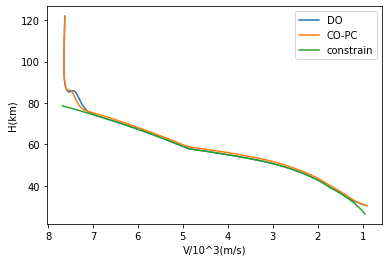

In [9]:
plt.figure()
plt.plot(V(e_values.flatten(),DO_Xk[0].flatten())*np.sqrt(g0*R0)/1000,(DO_Xk[0].flatten()-1)*R0/1000,label='DO')
plt.plot(V(e_values.flatten(),result_X[0][:,deterministic_idx].flatten())*np.sqrt(g0*R0)/1000,(rk[:,deterministic_idx].flatten()-1)*R0/1000,label='CO-PC')
path_constrain = path_constrain_init()
plt.plot(V(e_values.flatten(),path_constrain[:,deterministic_idx].flatten())*np.sqrt(g0*R0)/1000,(path_constrain[:,deterministic_idx].flatten()-1)*R0/1000,label='constrain')
plt.xlabel('V/10^3(m/s)')
plt.ylabel('H(km)')
plt.legend()
plt.gca().invert_xaxis()
plt.show()

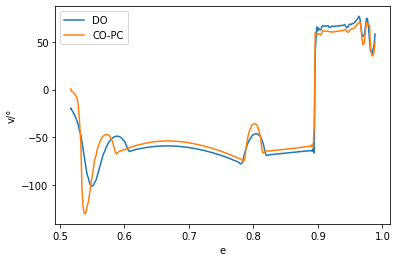

In [10]:
plt.plot(e_values.flatten(),np.arctan2(DO_u[1],DO_u[0])*180/np.pi,label='DO')
plt.plot(e_values.flatten(),np.arctan2(result_u[1],result_u[0])*180/np.pi,label='CO-PC')
plt.xlabel('e')
plt.ylabel('v/°')
plt.legend()
plt.show()

In [13]:
def MC(e_values,u_val,numOftest):
    Rhodelta,CLdelta,CDdelta = np.random.randn(numOftest)*deviation_Rho,np.random.randn(numOftest)*deviation_CL,np.random.randn(numOftest)*deviation_CD
    sigma_e = interp1d(e_values.flatten(),np.arctan2(u_val[1],u_val[0]).flatten()/np.pi*180, kind='linear',fill_value='extrapolate')
    gammak=[np.ones_like(Rhodelta)*float(gamma0)]
    thetak = [np.ones_like(Rhodelta)*float(theta0)]
    faik = [np.ones_like(Rhodelta)*float(fai0)]
    polyfaik = [np.ones_like(Rhodelta)*float(polyfai0)]
    rk = [np.ones_like(Rhodelta)*float(r0)]
    Vk = [np.ones_like(Rhodelta)*float(V0)]
    ek = [np.ones_like(Rhodelta)*float(e0)]
    tk = [np.zeros_like(Rhodelta)]
    dt = 1/np.sqrt(R0/g0)
    mask = rk[-1]>=rf
    while np.any(mask):
        dXdt_val = dXdt(rk[-1][mask],thetak[-1][mask],faik[-1][mask],gammak[-1][mask],polyfaik[-1][mask],ek[-1][mask],np.cos(sigma_e(ek[-1][mask])/180*np.pi),np.sin(sigma_e(ek[-1][mask])/180*np.pi),deterministic_idx,Rhodelta1=Rhodelta[mask],CLdelta1=CLdelta[mask],CDdelta1=CDdelta[mask])
        rk_tmp = rk[-1].copy()
        rk_tmp[mask] += (dt*dXdt_val[0])
        rk.append(rk_tmp)
        thetak_tmp = thetak[-1].copy()
        thetak_tmp[mask] += (dt*dXdt_val[1])
        thetak.append(thetak_tmp)
        faik_tmp = faik[-1].copy()
        faik_tmp[mask] += (dt*dXdt_val[2])
        faik.append(faik_tmp)
        gammak_tmp = gammak[-1].copy()
        gammak_tmp[mask] += (dt*dXdt_val[3])
        gammak.append(gammak_tmp)
        polyfaik_tmp = polyfaik[-1].copy()
        polyfaik_tmp[mask] += (dt*dXdt_val[4])
        polyfaik.append(polyfaik_tmp)
        Vk_tmp = Vk[-1].copy()
        Vk_tmp[mask] += (dt*dXdt_val[5])
        Vk.append(Vk_tmp)
        ek.append((1/rk[-1]-Vk[-1]**2/2))
        tk_tmp = tk[-1].copy()
        tk_tmp[mask]+=dt
        tk.append(tk_tmp)
        mask = rk[-1]>=rf
    rk = np.array(rk)
    thetak = np.array(thetak)
    faik = np.array(faik)
    gammak = np.array(gammak)
    polyfaik = np.array(polyfaik)
    Vk = np.array(Vk)
    tk = np.array(tk)
    ek = np.array(ek)
    return (rk,thetak,faik,gammak,polyfaik,Vk,tk,Rhodelta,CLdelta,CDdelta)
result_rk,result_thetak,result_faik,result_gammak,result_polyfaik,result_Vk,result_tk,result_Rhodelta,result_CLdelta,result_CDdelta = MC(e_values,result_u,3000)
DO_rk,DO_thetak,DO_faik,DO_gammak,DO_polyfaik,DO_Vk,DO_tk,DO_Rhodelta,DO_CLdelta,DO_CDdelta = MC(e_values,DO_u,3000)

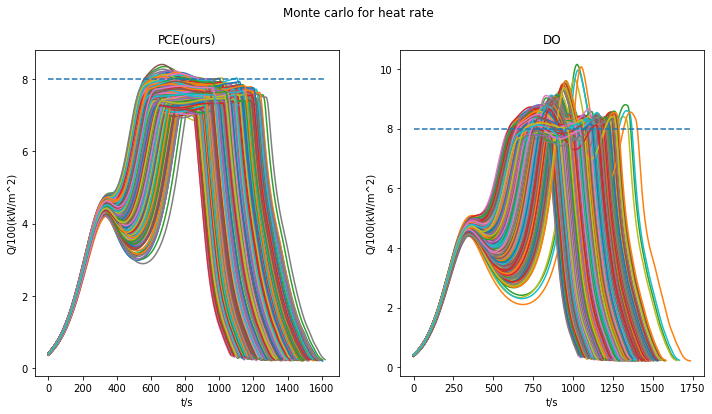

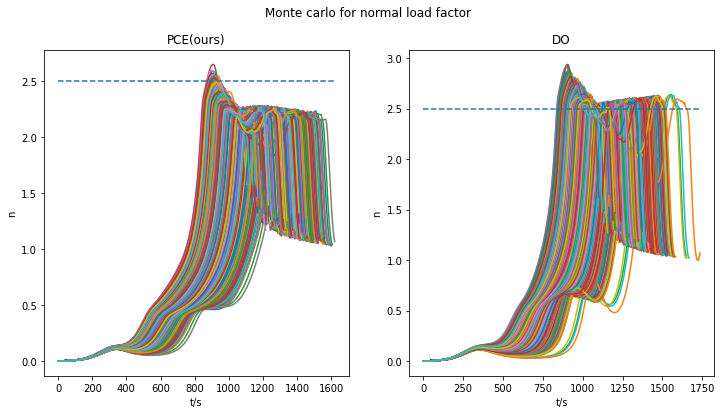

In [14]:
def L_(V,r,CLdelta=0,Rhodelta=0):#单位m/s^2
    Mach = V/sound_speed(r)
    return 0.5*R0*Rho(r,Rhodelta=Rhodelta)*V**2*Sref*CL(alpha(Mach),Mach,CLdelta=CLdelta)/(m)
def D_(V,r,CDdelta=0,Rhodelta=0):#单位m/s^2
    Mach = V/sound_speed(r)
    return 0.5*R0*Rho(r,Rhodelta=Rhodelta)*V**2*Sref*CD(alpha(Mach),Mach,CDdelta=CDdelta)/(m)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes[0].plot(result_tk*np.sqrt(R0/g0),kQ*np.sqrt(g0*R0)**3.15*np.sqrt(Rho(result_rk,Rhodelta=result_Rhodelta))*result_Vk**3.15/1000/100)
axes[0].plot([0,np.max(result_tk*np.sqrt(R0/g0))],[Qmax/1000/100,Qmax/1000/100],linestyle='--')
axes[0].set_title('PCE(ours)')
axes[0].set_xlabel('t/s')
axes[0].set_ylabel('Q/100(kW/m^2)')
axes[1].plot(DO_tk*np.sqrt(R0/g0),kQ*np.sqrt(g0*R0)**3.15*np.sqrt(Rho(DO_rk,Rhodelta=DO_Rhodelta))*DO_Vk**3.15/1000/100)
axes[1].plot([0,np.max(DO_tk*np.sqrt(R0/g0))],[Qmax/1000/100,Qmax/1000/100],linestyle='--')
axes[1].set_title('DO')
axes[1].set_xlabel('t/s')
axes[1].set_ylabel('Q/100(kW/m^2)')
plt.suptitle("Monte carlo for heat rate")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes[0].plot(result_tk*np.sqrt(R0/g0),np.sqrt(L_(result_Vk,result_rk,CLdelta=result_CLdelta,Rhodelta=result_Rhodelta)**2+D_(result_Vk,result_rk,CDdelta=result_CDdelta,Rhodelta=result_Rhodelta)**2))
axes[0].plot([0,np.max(result_tk*np.sqrt(R0/g0))],[nmax,nmax],linestyle='--')
axes[0].set_title('PCE(ours)')
axes[0].set_xlabel('t/s')
axes[0].set_ylabel('n')
axes[1].plot(DO_tk*np.sqrt(R0/g0),np.sqrt(L_(DO_Vk,DO_rk,CLdelta=DO_CLdelta,Rhodelta=DO_Rhodelta)**2+D_(DO_Vk,DO_rk,CDdelta=DO_CDdelta,Rhodelta=DO_Rhodelta)**2))
axes[1].plot([0,np.max(DO_tk*np.sqrt(R0/g0))],[nmax,nmax],linestyle='--')
axes[1].set_title('DO')
axes[1].set_xlabel('t/s')
axes[1].set_ylabel('n')
plt.suptitle("Monte carlo for normal load factor")
plt.show()